# **빅데이터 개론 Lab 13 - 랜덤 포레스트(Random Forests)**
실습관련 질문 : jjbblue12@hallym.ac.kr (전준범 조교 공학관 1314호 데이터베이스 연구실 )

실습 영상은 Google Colaboratory을 이용하여 진행.

notebook 파일 제공 예정

참고자료 : https://www.notion.so/TA-2689a38b5289413a82671d3956fea103

- - -




### **<앙상블 모델 (Ensemble model)>**

  * 앙상블(ensemble) 모델은 여러 개의 분류 모델에 의한 결과를 종합하여 분류의 정확도를 높이는 방법이다.
  * 여러 개의 모델을 합쳐 일반화 성능 향상 : 대중의 지혜(Wisdom of Crowd)
  * 표본추출법으로 원래 데이터에서 여러 개의 훈련용 데이터 집합을 만들어 각각의 데이터 집합에서 하나의 분류기를 만들어 앙상블 하는 방법이다. 
  * 새로운 자료에 대해 각 분류기의 예측값들의 가중 투표(weighted vote) 등을 통해 분류를 수행한다.

<br>

<p align="center"><img src="https://github.com/Jin0331/TA/blob/master/image/ensemble_1.png?raw=true" width="425"/> <img src="https://github.com/Jin0331/TA/blob/master/image/ensemble_2.png?raw=true" width="425"/></p>


* **개별 모형과 비교한 앙상블 모델의 장점**
  * 치우침이 있는 여러 모형의 평균을 취하면, 어느 쪽에도 치우치지 않는 결과(평균)를 얻게 된다.
  * 분산을 감소시킨다: 한 개 모형으로부터의 단일 의견보다 여러 모형의 의견을 결합하면 변동이 작아진다.
  * 과적합의 가능성을 줄여준다: 각 모형으로부터 예측을 결합하면 과적합의 여지가 줄어든다.

* **앙상블 방법**

  * **배깅 (bagging) : 중복을 허용하는 샘플링**
  * ~~부스팅(boosting) : 이전 예측기의 오차를 보완해서 샘플링~~
  * ~~페이스팅(pasting) : 중복을 허용하지 않는 샘플링~~
  * ~~스태킹(stacking) : 앙상블 결과 위에 예측을 위한 모델 추가~~

In [1]:
install.packages(c("tidyverse", "caret", "e1071", "ipred","randomForest"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘iterators’, ‘gower’, ‘timeDate’, ‘lava’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘proxy’, ‘prodlim’




### **앙상블 모델과 비교하기 위한 Decision Tree 생성 - Heart Disease Data이용** 

https://archive.ics.uci.edu/ml/datasets/heart+disease

* 변수 설명

```
Age : age in years
Sex: sex (1 = male; 0 = female) # Factor
ChestPain : (typical angina, atypical angina, non-anginal pain, asymptomatic # Factor
RestBP(혈압) : resting blood pressure
Chol(콜레스테롤 수치) : serum cholestoral in mg/dl
Fbs(혈당) : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) # Factor
Restecg(심전도) : (0 = normal, 1 = having ST-T wave abnormality, 2 =  showing probable or definite left ventricular hypertrophy by Estes' criteria) # Factor
MaxHR : maximum heart rate achieved
ExAng(협심증?): exercise induced angina (1 = yes; 0 = no) # Factor
Oldpeak = ST depression induced by exercise relative to rest
Slope: the slope of the peak exercise ST segment(1 = upsloping, 2 = flat, 3 = downsloping) # Factor
Ca: number of major vessels (0-3) colored by flourosopy # Factor
Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect # Factor

# the predicted attribute(반응변수)

AHD : diagnosis of heart disease (angiographic disease status)(0 = < 50% diameter narrowing, 1 =  > 50% diameter narrowing)

# http://archive.ics.uci.edu/ml/datasets/heart+Disease
```


In [4]:
library(tidyverse)
heart_df <- read_csv("https://raw.githubusercontent.com/Jin0331/TA/master/data/heart/Heart.csv")
str(heart_df)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

New names:
* `` -> ...1

Rows: 303 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): ChestPain, Thal, AHD
dbl (12): ...1, Age, Sex, RestBP, Chol, Fbs, RestECG, MaxHR, ExAng, Oldpeak,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



spec_tbl_df [303 × 15] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1     : num [1:303] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age      : num [1:303] 63 67 67 37 41 56 62 57 63 53 ...
 $ Sex      : num [1:303] 1 1 1 1 0 1 0 0 1 1 ...
 $ ChestPain: chr [1:303] "typical" "asymptomatic" "asymptomatic" "nonanginal" ...
 $ RestBP   : num [1:303] 145 160 120 130 130 120 140 120 130 140 ...
 $ Chol     : num [1:303] 233 286 229 250 204 236 268 354 254 203 ...
 $ Fbs      : num [1:303] 1 0 0 0 0 0 0 0 0 1 ...
 $ RestECG  : num [1:303] 2 2 2 0 2 0 2 0 2 2 ...
 $ MaxHR    : num [1:303] 150 108 129 187 172 178 160 163 147 155 ...
 $ ExAng    : num [1:303] 0 1 1 0 0 0 0 1 0 1 ...
 $ Oldpeak  : num [1:303] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ Slope    : num [1:303] 3 2 2 3 1 1 3 1 2 3 ...
 $ Ca       : num [1:303] 0 3 2 0 0 0 2 0 1 0 ...
 $ Thal     : chr [1:303] "fixed" "normal" "reversable" "normal" ...
 $ AHD      : chr [1:303] "No" "Yes" "Yes" "No" ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1

* mutate를 이용한 데이터 타입 변경(int or chr ---> factor)

In [5]:
heart_df <- heart_df %>% 
 mutate_at(`.vars` = c("Sex", "ChestPain", "Fbs", "RestECG", "ExAng", "Slope", "Ca", "Thal", "AHD"), `.funs` = as.factor)
heart_df %>% str()

spec_tbl_df [303 × 15] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1     : num [1:303] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age      : num [1:303] 63 67 67 37 41 56 62 57 63 53 ...
 $ Sex      : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 1 2 2 ...
 $ ChestPain: Factor w/ 4 levels "asymptomatic",..: 4 1 1 2 3 3 1 1 1 1 ...
 $ RestBP   : num [1:303] 145 160 120 130 130 120 140 120 130 140 ...
 $ Chol     : num [1:303] 233 286 229 250 204 236 268 354 254 203 ...
 $ Fbs      : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 2 ...
 $ RestECG  : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 1 3 1 3 3 ...
 $ MaxHR    : num [1:303] 150 108 129 187 172 178 160 163 147 155 ...
 $ ExAng    : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 2 ...
 $ Oldpeak  : num [1:303] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ Slope    : Factor w/ 3 levels "1","2","3": 3 2 2 3 1 1 3 1 2 3 ...
 $ Ca       : Factor w/ 4 levels "0","1","2","3": 1 4 3 1 1 1 3 1 2 1 ...
 $ Thal     : Factor w/ 3 levels "fixed","normal",..: 1 2 

* **train-test split**

In [6]:
library(caret) 
set.seed(31)
index <- createDataPartition(y = heart_df$AHD, p = 0.7, list = FALSE) 
train <- heart_df[index, ]
test <- heart_df[-index, ]

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




* Decision Tree Model 생성

In [26]:
library(rpart)
AHD_detection <- rpart(formula = AHD ~ ., data = train, method = "class")

  - xerror(cross validation error)가 최소가 되는 CP를 선택

In [27]:
min_xerror_cp <- AHD_detection$cptable %>% as_tibble() %>%
  filter(xerror == min(xerror)) %>% pull(CP)

In [28]:
min_xerror_cp

[1] 0.01020408

* prune

In [29]:
AHD_detection_pr <- rpart::prune(AHD_detection, cp = min_xerror_cp)

* **test를 이용한 예측 및 평가**

In [30]:
test %>% show()

# A tibble: 90 × 15
    ...1   Age Sex   ChestPain    RestBP  Chol Fbs   RestECG MaxHR ExAng Oldpeak
   <dbl> <dbl> <fct> <fct>         <dbl> <dbl> <fct> <fct>   <dbl> <fct>   <dbl>
 1     1    63 1     typical         145   233 1     2         150 0         2.3
 2     8    57 0     asymptomatic    120   354 0     0         163 1         0.6
 3    10    53 1     asymptomatic    140   203 1     2         155 1         3.1
 4    13    56 1     nonanginal      130   256 1     2         142 1         0.6
 5    17    48 1     nontypical      110   229 0     0         168 0         1  
 6    18    54 1     asymptomatic    140   239 0     0         160 0         1.2
 7    19    48 0     nonanginal      130   275 0     0         139 0         0.2
 8    37    43 1     asymptomatic    120   177 0     2         120 1         2.5
 9    38    57 1     asymptomatic    150   276 0     2         112 1         0.6
10    41    65 0     asymptomatic    150   225 0     2         114 0         1  
# … with

In [31]:
predict_value <- predict(AHD_detection_pr, test, type = "class") %>% 
 tibble(predict_value = .)
predict_check <- test %>% select(AHD) %>% dplyr::bind_cols(., predict_value) 

In [42]:
predict_check %>% show()

# A tibble: 90 × 2
   AHD   predict_value
   <fct> <fct>        
 1 No    No           
 2 No    No           
 3 Yes   Yes          
 4 Yes   Yes          
 5 Yes   No           
 6 No    No           
 7 No    No           
 8 Yes   Yes          
 9 Yes   Yes          
10 Yes   Yes          
# … with 80 more rows


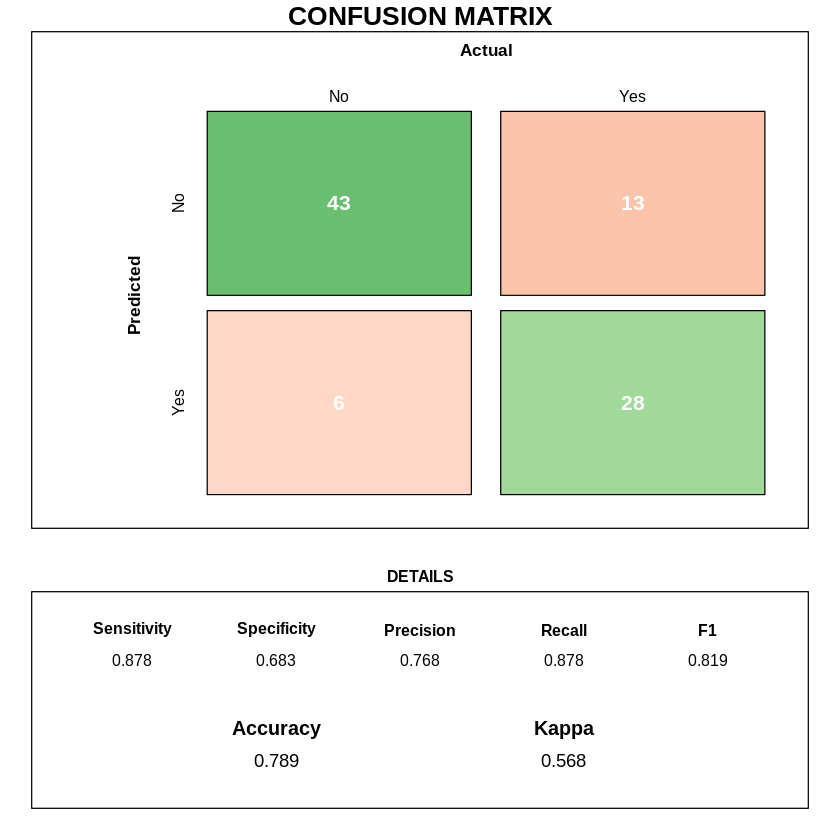

In [32]:
cm <- caret::confusionMatrix(predict_value$predict_value, test$AHD)
draw_confusion_matrix(cm)

#### **배깅(Bagging)**

* 배깅(bagging) : ``중복``을 허용하는 샘플링. Bootstrap Aggregation의 줄임말
  * *통계학에서는 중복을 허용하는 샘플링을 부트스트래핑(bootstrapping)이라고 함*

* 배깅은 중복 추출 방법을 사용하기 때문에 같은 데이터가 한 데이터셋에  여러 번 추출될 수도 있고, 어떤 데이터는 추출되지 않을 수도 있다.

* 데이터가 충분히 큰 경우, 각 데이터가 하나의 붓스트랩 표본에서 제외될 확률은 36.78%이다

<br>

<p align="center"><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbTZVqu%2Fbtqw4oKck4I%2FKbO0ih5GDB5qP2HNtUsGa0%2Fimg.png" width="600"/> 

<p align="center"><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FReb8Q%2Fbtqw5gkMnjn%2FaWVHsgQihxY7wmaNEN8Ay0%2Fimg.jpg" width="600"/> 

* bagging

<p align="center"><img src="https://github.com/Jin0331/TA/blob/master/image/bagging.png?raw=true" width="600"/></p>


In [14]:
library(ipred)

In [43]:
set.seed(66)
AHD_bagging <- ipred::bagging(AHD ~ ., data = train, nbagg = 100)

In [44]:
predict_value <- predict(AHD_bagging, test, type = "class") %>% 
 tibble(predict_value = .)
predict_check <- test %>% select(AHD) %>% dplyr::bind_cols(., predict_value) 

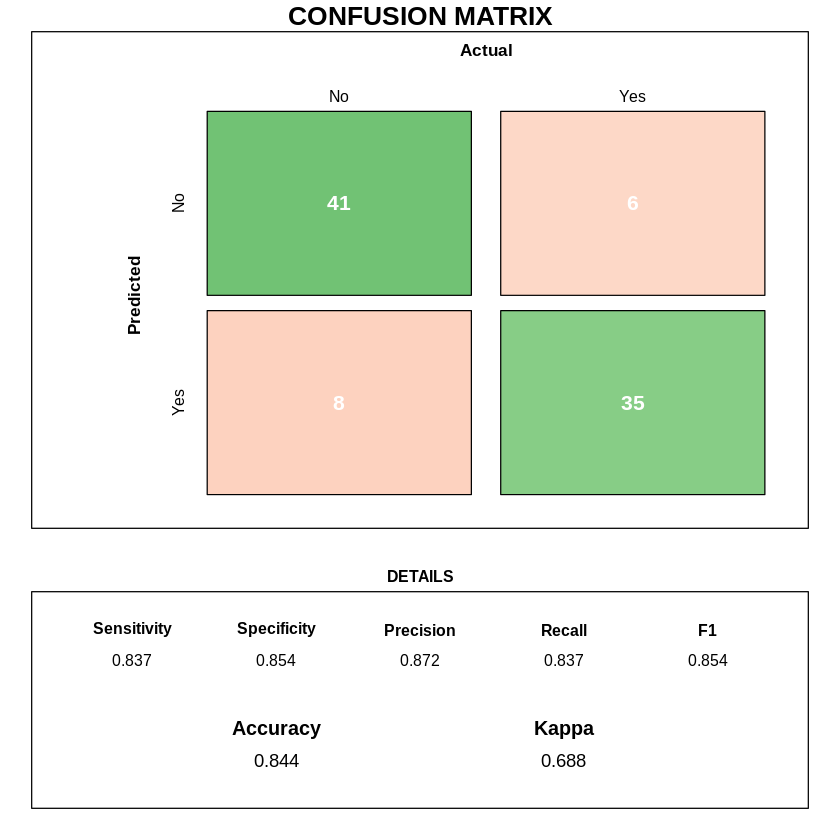

In [17]:
cm <- caret::confusionMatrix(predict_value$predict_value, test$AHD)
draw_confusion_matrix(cm)

### **<랜덤 포레스트(Random Forests)>**

* 랜덤포레스트(random forest)는 배깅에 랜덤과정(설명변수)을 추가한 방법이다.
* 원래 트레이닝  자료로부터 붓스트랩 샘플을 추출하고, 각 붓스트랩 샘플에 대해 트리를 형성해 나가는 과정은 배깅과 유사하나, 각 노드마다 모든 예측변수 안에서 최적의 분할(split)을 선택하는 방법 대신 예측변수들을 임의로 추출하고, 추출된 변수 내에서 최적의 분할을 만들어 나가는 방법을 사용한다.
* 새로운 자료에 대한 예측은 분류(classification)의 경우는 다수결(majority votes)로, 회귀(regression)의 경우에는 평균을 취하는 방법을 사용한다.

<br>

<p align="center"><img src="https://github.com/Jin0331/TA/blob/master/image/random_forests.jpg?raw=true" width="550"></p>


* __배깅과 랜덤 포레스트의 차이?__
  * 배깅의 일종. 배깅과 다른 점은, ``'설명변수'도 무작위로 선택``. 즉, 설명변수를 무작위로 선택함으로써, 트리의 다양성을 확보하여 모형간의 상관관계를 줄이고자 하는 것



In [33]:
#install.packages("randomForest")
library(randomForest)

In [35]:
summary(train)

      ...1            Age        Sex            ChestPain       RestBP     
 Min.   :  2.0   Min.   :34.00   0: 72   asymptomatic:101   Min.   :100.0  
 1st Qu.: 79.0   1st Qu.:48.00   1:141   nonanginal  : 56   1st Qu.:120.0  
 Median :157.0   Median :56.00           nontypical  : 38   Median :130.0  
 Mean   :154.9   Mean   :55.04           typical     : 18   Mean   :132.8  
 3rd Qu.:232.0   3rd Qu.:62.00                              3rd Qu.:140.0  
 Max.   :303.0   Max.   :77.00                              Max.   :200.0  
      Chol       Fbs     RestECG     MaxHR       ExAng      Oldpeak     
 Min.   :141.0   0:184   0:113   Min.   : 71.0   0:144   Min.   :0.000  
 1st Qu.:212.0   1: 29   1:  4   1st Qu.:133.0   1: 69   1st Qu.:0.000  
 Median :242.0           2: 96   Median :155.0           Median :0.800  
 Mean   :246.9                   Mean   :149.9           Mean   :1.053  
 3rd Qu.:274.0                   3rd Qu.:168.0           3rd Qu.:1.600  
 Max.   :564.0                

In [36]:
AHD_RF <- randomForest(AHD ~ . -1, data = train, na.action = na.omit, importance = T, mtry = 7, ntree = 1000)
AHD_RF


Call:
 randomForest(formula = AHD ~ . - 1, data = train, importance = T,      mtry = 7, ntree = 1000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 7

        OOB estimate of  error rate: 19.71%
Confusion matrix:
    No Yes class.error
No  92  19   0.1711712
Yes 22  75   0.2268041

* mtry 골드 스탠다드(gold standard) : sqrt(설명변수 개수)

In [45]:
mtry_sqrt <- train %>% select( -1, -AHD) %>% colnames() %>%
 length() %>% sqrt() %>% floor()

mtry_sqrt

[1] 3

In [46]:
set.seed(52)
AHD_RF <- randomForest(AHD ~ . -1, data = train, na.action = na.omit, importance = T, mtry = mtry_sqrt, ntree = 1000)
AHD_RF


Call:
 randomForest(formula = AHD ~ . - 1, data = train, importance = T,      mtry = mtry_sqrt, ntree = 1000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 17.79%
Confusion matrix:
    No Yes class.error
No  97  14   0.1261261
Yes 23  74   0.2371134

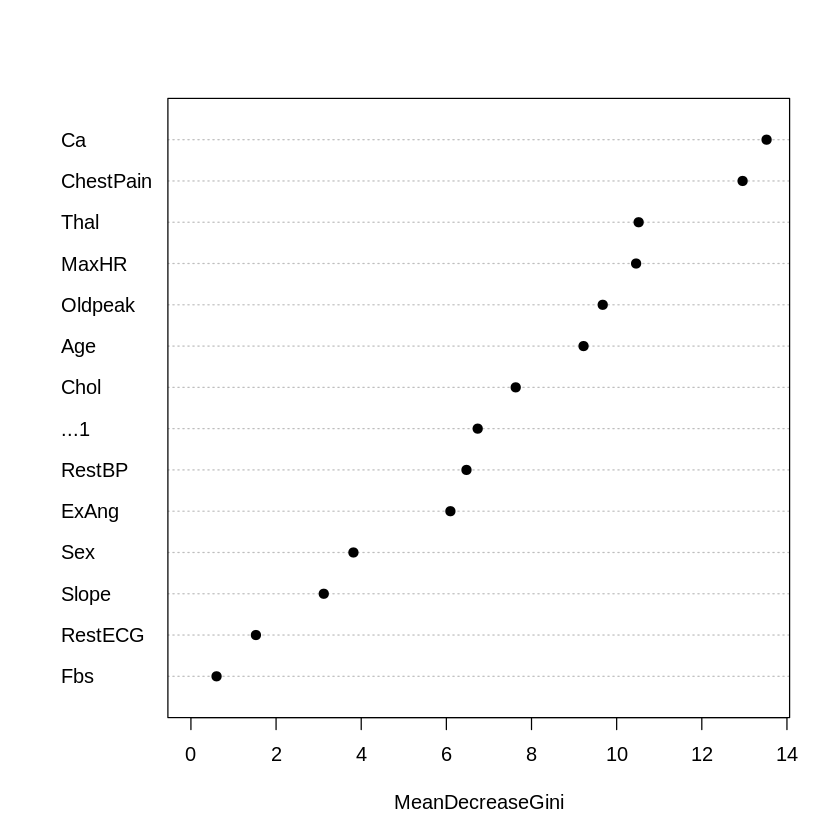

In [39]:
varImpPlot(AHD_RF, type=2, pch=19, col=1, cex=1, main="")

* 예측 및 평가

In [40]:
predict_value <- predict(AHD_RF, test, type = "class") %>% 
 tibble(predict_value = .)
predict_check <- test %>% select(AHD) %>% dplyr::bind_cols(., predict_value) 

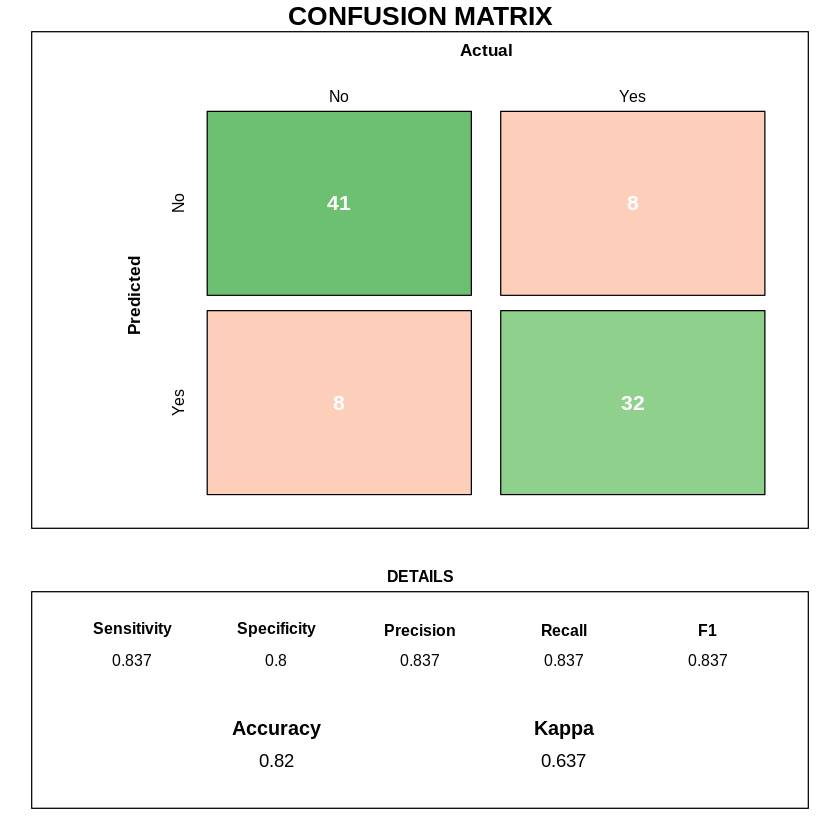

In [41]:
cm <- caret::confusionMatrix(predict_value$predict_value, test$AHD)
draw_confusion_matrix(cm)

### Confusion Matrix plot code

In [2]:
#https://stackoverflow.com/questions/23891140/r-how-to-visualize-confusion-matrix-using-the-caret-package

draw_confusion_matrix <- function(cm) {

  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  # Generate color gradients. Palettes come from RColorBrewer.
  greenPalette <- c("#F7FCF5","#E5F5E0","#C7E9C0","#A1D99B","#74C476","#41AB5D","#238B45","#006D2C","#00441B")
  redPalette <- c("#FFF5F0","#FEE0D2","#FCBBA1","#FC9272","#FB6A4A","#EF3B2C","#CB181D","#A50F15","#67000D")
  getColor <- function (greenOrRed = "green", amount = 0) {
    if (amount == 0)
      return("#FFFFFF")
    palette <- greenPalette
    if (greenOrRed == "red")
      palette <- redPalette
    colorRampPalette(palette)(100)[10 + ceiling(90 * amount / total)]
  }

  # set the basic layout
  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col=getColor("green", res[1]))
  text(195, 435, classes[1], cex=1.2)
  rect(250, 430, 340, 370, col=getColor("red", res[3]))
  text(295, 435, classes[2], cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col=getColor("red", res[2]))
  rect(250, 305, 340, 365, col=getColor("green", res[4]))
  text(140, 400, classes[1], cex=1.2, srt=90)
  text(140, 335, classes[2], cex=1.2, srt=90)

  # add in the cm results
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}